In [1]:
import csv
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [2]:
def read_process_write(inpath, outpath):
    """
    Reads data from a CoNLL format file, processes it, and writes the modified data to a new file.

    This function performs the following operations:
    - Reads a tab-separated file with no header, assuming the columns represent Token, POS, Chunk, and Named Entity (NE).
    - Removes any rows with missing data.
    - Processes the 'NE' column by keeping 'O' as is or stripping the first two characters for other NE tags (BIO tags).
    - Writes the processed data to a new tab-separated file without headers.

    :param inpath: Path to the input file in CoNLL format.
    :param outpath: Path where the processed file will be saved.
    :type inpath: str
    :type outpath: str
    """
    
    column_names = ["Token","POS", "Chunk", "NE"]
    the_data = pd.read_csv(inpath, sep='\t', header=None, names=column_names, skip_blank_lines=False)
    the_data.dropna(how='any', inplace=True)

    categories = the_data['NE'].tolist()
    
    token_cat = []
    
    for cat in categories:
        if cat == 'O':
            #print(cat)
            token_cat.append(cat)
        else:
            cat = cat[2:]
            token_cat.append(cat)

    the_data['NE'] = token_cat

    the_data.to_csv(outpath, sep='\t', index=False, header=None)

In [3]:
def extract_embeddings_as_features_and_gold(conllfile, embedding_model):
    """
    Function that extracts features and gold labels using word embeddings
    
    :param conllfile: path to conll file
    :param embedding_model: a pretrained word embedding model
    :type conllfile: string
    :type embedding_model: gensim.models.keyedvectors.Word2VecKeyedVectors
    
    :return features: list of vector representation of tokens
    :return labels: list of gold labels
    """
    
    # Load the pre-trained word embedding model
    print('load the word embedding model')
    word_embedding_model = KeyedVectors.load_word2vec_format(embedding_model, binary=True)
    print('1')

    labels = []
    features = []
    
    conllinput = open(conllfile, 'r')
    csvreader = csv.reader(conllinput, delimiter='\t', quotechar='|')

    current_sentence_tokens = []

    for row in csvreader:
        # Check for cases where the row is not empty
        if row:
            current_token = row[0]
            if current_token in word_embedding_model:
                current_vector = word_embedding_model[current_token]
            else:
                current_vector = [0] * 300

            current_sentence_tokens.append((current_token, current_vector, row[-1]))

    # Process the entire sequence of tokens for the sentence
    # ChatGPT has been utilized to retrieve POS and Token window information.
    for i in range(len(current_sentence_tokens)):
        current_token, current_vector, label = current_sentence_tokens[i]

        # Use a zero vector for the previous token if it's the first token in the sentence
        prev_vector = current_sentence_tokens[i - 1][1] if i > 0 else [0] * 300

        # Use a zero vector for the next token if it's the last token in the sentence
        next_vector = current_sentence_tokens[i + 1][1] if i < len(current_sentence_tokens) - 1 else [0] * 300

        # Combine current, previous, and next token's word embeddings
        combined_vector = np.concatenate((prev_vector, current_vector, next_vector), axis=-1)

        features.append(combined_vector)
        labels.append(label)

    return features, labels

In [4]:
def extract_features_and_labels(inputfile):
    """
    Extract features and labels from a text file for named entity recognition.

    This function reads a file where each line contains a token and its associated POS tag and named entity tag.
    It extracts features for each token and the corresponding named entity tag as the label.

    Features include:
    - Whether the token is capitalized or all in uppercase.
    - The current, previous, and next POS tags.
    The 'prevPos' feature is set to 'START' for the first token and 'nextPos' is set to 'END' for the last token.

    :param inputfile: Path to the input file.
    :type inputfile: tsv

    :return: A tuple containing two lists: one for the features and one for the targets (labels).
    """
    data = []
    targets = []
    prev_pos_tag = None  # Initialize the previous POS tag

    with open(inputfile, 'r', encoding='utf8') as infile:
        lines = infile.readlines()  # Read all lines into a list
        # Iterate over lines using zip to also access next line
        for current_line, next_line in zip(lines, lines[1:] + ['']):
            current_components = current_line.rstrip('\n').split()
            next_components = next_line.rstrip('\n').split()

            token = current_components[0]
            pos_tag = current_components[1]

            # Check for the case when the token is uppercase
            if token.isupper():
                feature_dict = {'isCapital': 1, 'isallCapital': 1, 'pos': pos_tag}
            # Check for the case when the initial character of the token is uppercase
            elif token[0].isupper():
                feature_dict = {'isCapital': 1, 'isallCapital': 0, 'pos': pos_tag}
            else:
                feature_dict = {'isCapital': 0, 'isallCapital': 0, 'pos': pos_tag}

            # Add previous and next POS tags as features
            # ChatGPT has been utilized to retrieve POS and Token window information.
            feature_dict['prevPos'] = prev_pos_tag if prev_pos_tag else 'START'
            feature_dict['nextPos'] = next_components[1] if len(next_components) > 1 else 'END'

            data.append(feature_dict)

            # Update the previous POS tag for the next iteration
            prev_pos_tag = pos_tag
            targets.append(current_components[-1])
    return data, targets

In [5]:
def extract_features(inputfile):
    """
    Extract features from a text file for named entity recognition.

    This function reads a file where each line contains a token and its associated POS tag and named entity tag.
    It extracts features for each token and the corresponding named entity tag as the label.

    Features include:
    - Whether the token is capitalized or all in uppercase.
    - The current, previous, and next POS tags.
    The 'prevPos' feature is set to 'START' for the first token and 'nextPos' is set to 'END' for the last token.

    :param inputfile: Path to the input file.
    :type inputfile: tsv

    :return: A list containing feature values
    """
    data = []
    prev_pos_tag = None  # Initialize the previous POS tag

    with open(inputfile, 'r', encoding='utf8') as infile:
        lines = infile.readlines()  # Read all lines into a list
        for current_line, next_line in zip(lines, lines[1:] + ['']):
            current_components = current_line.rstrip('\n').split()
            next_components = next_line.rstrip('\n').split()
            # print(current_components)
            

            token = current_components[0]
            pos_tag = current_components[1]

            # Check for the case when the token is uppercase
            if token.isupper():
                feature_dict = {'isCapital': 1, 'isallCapital': 1, 'pos': pos_tag}
            # Check for the case when the initial character of the token is uppercase
            elif token[0].isupper():
                feature_dict = {'isCapital': 1, 'isallCapital': 0, 'pos': pos_tag}
            else:
                feature_dict = {'isCapital': 0, 'isallCapital': 0, 'pos': pos_tag}

            # Add previous and next POS tags as features
            # ChatGPT has been utilized to retrieve POS and Token window information.
            feature_dict['prevPos'] = prev_pos_tag if prev_pos_tag else 'START'
            feature_dict['nextPos'] = next_components[1] if len(next_components) > 1 else 'END'

            data.append(feature_dict)

            # Update the previous POS tag for the next iteration
            prev_pos_tag = pos_tag

    return data

In [6]:
def extract_features_and_labels_one_hot_token(trainingfile):
    """
    Extract features and labels from a training file for named entity recognition, including one-hot encoding for tokens.

    This function reads a file where each line contains a token and its associated POS tag and named entity tag.
    It extracts a comprehensive set of features for each token, which includes:
    - The token itself.
    - Whether the token is capitalized or all in uppercase.
    - The current, previous, and next POS tags.
    - The previous and next tokens in the sequence.
    The 'prevPos', 'prevToken' features are set to 'START' for the first token and 'nextPos', 'nextToken' to 'END' for the last token.

    :param trainingfile: Path to the training file.
    :type trainingfile: str

    :return: A tuple containing two lists: one for the features and one for the targets (labels).
    """
    data = []
    targets = []
    prev_pos_tag = None  # Initialize the previous POS tag

    with open(trainingfile, 'r', encoding='utf8') as infile:
        lines = infile.readlines()  # Read all lines into a list
        # Iterate over lines using zip to also access next line
        for current_line, next_line in zip(lines, lines[1:] + ['']):
            current_components = current_line.rstrip('\n').split()
            next_components = next_line.rstrip('\n').split()

            token = current_components[0]
            pos_tag = current_components[1]

            # Check for the case when the token is uppercase
            if token.isupper():
                feature_dict = {'token': token, 'isCapital': 1, 'isallCapital': 1, 'pos': pos_tag}
            # Check for the case when the initial character of the token is uppercase
            elif token[0].isupper():
                feature_dict = {'token': token, 'isCapital': 1, 'isallCapital': 0, 'pos': pos_tag}
            else:
                feature_dict = {'token': token, 'isCapital': 0, 'isallCapital': 0, 'pos': pos_tag}

            # Add previous and next POS tags as features
            # ChatGPT has been utilized to retrieve POS and Token window information.
            feature_dict['prevPos'] = prev_pos_tag if prev_pos_tag else 'START'
            feature_dict['nextPos'] = next_components[1] if len(next_components) > 1 else 'END'

            # Add previous, current, and next tokens as features
            feature_dict['prevToken'] = lines[lines.index(current_line) - 1].split()[0] if prev_pos_tag else 'START'
            feature_dict['nextToken'] = next_components[0] if len(next_components) > 0 else 'END'

            data.append(feature_dict)

            # Update the previous POS tag for the next iteration
            prev_pos_tag = pos_tag
            targets.append(current_components[-1])
    return data, targets

In [7]:
def combine_features_train(we_features, file_path):
    """
    Combines word embedding features with traditional features for training data.

    This function reads traditional features and targets from a file and vectorizes these features.
    It then concatenates the vectorized traditional features with precomputed word embedding features.

    :param we_features: Precomputed word embedding features.
    :param file_path: Path to the file containing traditional features and labels.
    :type we_features: numpy.ndarray

    :return: A tuple containing the combined feature set and the vectorizer used for traditional features.
    """
    # Extract traditional features and targets from the file
    trad_features, trad_targets = extract_features_and_labels(file_path)
    
    # Convert traditional features into vectorized form
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(trad_features)
    feature_vec_array = features_vectorized.toarray()
    
     # Concatenate word embedding features with vectorized traditional features
    combined_features = np.concatenate((we_features, feature_vec_array), axis=-1)
    # Return the combined features and the vectorizer
    return combined_features, vec

def combine_features_test(we_features, file_path, vec):
    """
    Combines word embedding features with traditional features for test data.

    This function reads traditional features from a test file and transforms these features using a
    pre-trained DictVectorizer. It then concatenates the transformed traditional features with
    precomputed word embedding features.

    :param we_features: Precomputed word embedding features for the test set.
    :param file_path: Path to the file containing traditional features for the test set.
    :param vec: A pre-trained DictVectorizer used to transform traditional features.
    :type we_features: numpy.ndarray
    :type vec: sklearn.feature_extraction.DictVectorizer

    :return: Combined feature set for the test data.
    """
    
    trad_features, trad_targets = extract_features_and_labels(file_path)
    
    # Create one hot repr for traditional features
    # Use the vectorizer that we created for training
    features_vectorized = vec.transform(trad_features)
    feature_vec_array = features_vectorized.toarray()
    
    # Concatenate vectors
    combined_features = np.concatenate((we_features, feature_vec_array), axis=-1)
    # Return the combined features
    return combined_features

In [8]:
def create_classifier(train_features, train_targets, modelname, we=None):
    """
    Creates and trains a classifier based on the specified model name and feature type.

    Supported models:
    - Logistic Regression ('logreg')
    - Support Vector Machine ('svm')
    - Multinomial Naive Bayes ('nb')

    :param train_features: Training feature set.
    :param train_targets: Training target labels.
    :param modelname: Name of the model to train ('logreg', 'svm', 'nb').
    :param we: Indicates if word embeddings are used ('yes' or 'no').
    :type train_features: list or numpy.ndarray
    :type train_targets: list or numpy.ndarray

    :return: The trained model, and the DictVectorizer if used.
    """
    # Logistic Regression with one-hot encoding
    if modelname == 'logreg' and we == 'no': # Only if one-hot encoding features
        model = LogisticRegression(max_iter=10000)
        vec = DictVectorizer()
        features_vectorized = vec.fit_transform(train_features)
        model.fit(features_vectorized, train_targets)
    # Logistic Regression with word embeddings
    if modelname == 'logreg' and we == 'yes':
        model = LogisticRegression(max_iter=10000)
        model.fit(train_features, train_targets) # Our features are already vectorized
        
    # SVM with word embeddings
    elif modelname == 'svm' and we =='yes':
        model = SVC(C=10, kernel='rbf', gamma='scale')  # You might want to adjust parameters for SVC based on your requirements
        model.fit(train_features, train_targets)
    
    # Multinomial Naive Bayes with one-hot encoding 
    elif modelname == 'nb' and we=='no':
        vec = DictVectorizer()
        features_vectorized = vec.fit_transform(train_features)
        model = MultinomialNB()
        model.fit(features_vectorized, train_targets)
        
    else:
        raise ValueError("Invalid model name. Supported models: 'logreg', 'svm', 'nb'")
    
    # Return model and vectorizer if applicable
    if (modelname == 'logreg' or modelname == 'svm') and we == 'yes':
        return model
    else:
        return model, vec

In [9]:
def classify_data_we(model, inputdata, we_model_path, outputfile, vec):
    """
    Classifies data using a pre-trained model and word embeddings, and writes the results to an output file.

    This function performs the following steps:
    - Extracts word embedding features and labels from the input data.
    - Combines these features with additional features extracted from the input data using a pre-trained vectorizer.
    - Uses the provided model to predict the class for each data point.
    - Writes the original data along with its predicted class to an output file.

    :param model: The pre-trained classification model.
    :param inputdata: Path to the input data file.
    :param we_model_path: Path to the word embedding model.
    :param outputfile: Path to the file where the output will be written.
    :param vec: Pre-trained DictVectorizer for transforming traditional features.
    :type model: A trained classifier model.
    :type vec: sklearn.feature_extraction.DictVectorizer
    """
    # Extract word embedding features and labels
    we_features, labels = extract_embeddings_as_features_and_gold(inputdata,we_model_path)
    print('word embeddings retrieval for dev data is done')
    print(len(we_features))
    
    # Combine word embedding features with additional features
    combined_features = combine_features_test(we_features, inputdata, vec)
    print('features combined')
    
    # Predict using the model
    predictions = model.predict(combined_features)
    print('model.predict')
    # Write predictions to output file
    outfile = open(outputfile, 'w')
    counter = 0
    for line in open(inputdata, 'r'):
        if len(line.rstrip('\n').split()) > 0:
            outfile.write(line.rstrip('\n') + '\t' + predictions[counter] + '\n')
            counter += 1
    outfile.close()
    print('Output written to file.')

In [10]:
def classify_data_one_hot(model, vec, inputdata, outputfile):
    """
    Classifies data using a pre-trained model with one-hot encoded features and writes the results to an output file.

    This function performs the following steps:
    - Extracts features from the input data and transforms them using a pre-trained DictVectorizer.
    - Uses the provided model to predict the class for each data point.
    - Writes the original data along with its predicted class to an output file.

    :param model: The pre-trained classification model.
    :param vec: Pre-trained DictVectorizer used for transforming features into one-hot encoded vectors.
    :param inputdata: Path to the input data file.
    :param outputfile: Path to the file where the output will be written.
    :type model: A trained classifier model.
    :type vec: sklearn.feature_extraction.DictVectorizer
    """
    # Extract features and transform them using the vectorizer
    test_features, test_targets = extract_features_and_labels_one_hot_token(inputdata)
    features = vec.transform(test_features)
    # Predict using the model
    predictions = model.predict(features)
    # Write predictions to output file
    outfile = open(outputfile, 'w')
    counter = 0
    for line in open(inputdata, 'r'):
        if len(line.rstrip('\n').split()) > 0:
            outfile.write(line.rstrip('\n') + '\t' + predictions[counter] + '\n')
            counter += 1
    outfile.close()
    print('Output written to file.')

In [11]:
def predictions_file(prediction):
    predictions1 = []
    with open(prediction, 'r') as output:
        for line in output:
            splitted = line.strip('\n').split('\t')
            predictions1.append(splitted[-1]) #populate the list with prediction labels
    return predictions1 # return the list for classification report

In [12]:
def svm(prediction_file):
    """
    Trains an SVM classifier using word embeddings and additional features, classifies test data,
    and evaluates the model's performance.

    The function performs the following steps:
    1. Trains an SVM model using training features and labels.
    2. Classifies test data using the trained model.
    3. Extracts actual labels from the test data.
    4. Reads predicted labels from a specified file.
    5. Generates and prints a classification report and a confusion matrix.
    6. Visualizes the confusion matrix.

    :param prediction_file: Path to the file where the SVM model's predictions are saved.
    :type prediction_file: str
    """

    # Train the SVM model
    # 'train_feat_combined' and 'train_we_labels' should be predefined with your training data
    model = create_classifier(train_feat_combined, train_we_labels, 'svm', we='yes')
    print('model created')

    # Classify the test data
    # 'outpath_test', 'model_path', and 'train_vec' should be correctly set
    classify_data_we(model, outpath_test, model_path, prediction_file, train_vec)
    print('data classified')
    # Extract actual labels from the test data
    # Ensure 'outpath_test' points to the correct file with test data
    test_features, test_labels = extract_features_and_labels(outpath_test)
    print('test features extracted')
    # Read predictions from the prediction file
    predictions1 = predictions_file(prediction_file)

    # Generate and print the classification report and confusion matrix
    report = classification_report(test_labels, predictions1, digits=4)
    matrix1 = confusion_matrix(test_labels, predictions1)
    print(report)
    print(matrix1)

    # Visualize the confusion matrix
    # Use unique class labels for the display
    unique_labels = sorted(set(test_labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix1, display_labels=unique_labels)
    disp.plot()


In [13]:
def logreg(prediction_file):
    """
    Trains a logistic regression classifier using word embeddings and additional features, classifies test data,
    and evaluates the model's performance.

    The function performs the following steps:
    1. Trains a logistic regression model using training features and labels.
    2. Classifies test data using the trained model.
    3. Extracts actual labels from the test data.
    4. Reads predicted labels from a specified file.
    5. Generates and prints a classification report and a confusion matrix.
    6. Visualizes the confusion matrix.

    :param prediction_file: Path to the file where the logistic regression model's predictions are saved.
    """

    # Train the logistic regression model
    # Ensure 'train_feat_combined' and 'train_we_labels' are predefined with your training data
    model = create_classifier(train_feat_combined, train_we_labels, 'logreg', we='yes')
    print('model created')
    # Classify the test data
    # Ensure 'outpath_test', 'model_path', and 'train_vec' are correctly set
    classify_data_we(model, outpath_test, model_path, prediction_file, train_vec)
    print('data classified')
    # Extract actual labels from the test data
    # Ensure 'outpath_test' points to the correct file with test data
    test_features, test_labels = extract_features_and_labels(outpath_test)
    print('test features extracted')
    # Read predictions from the prediction file
    # The 'predictions_file' function should parse the prediction file correctly
    predictions1 = predictions_file(prediction_file)

    # Generate and print the classification report and confusion matrix
    report = classification_report(test_labels, predictions1, digits=4)
    matrix1 = confusion_matrix(test_labels, predictions1)
    print(report)
    print(matrix1)

    # Visualize the confusion matrix
    # Use unique class labels for the display
    unique_labels = sorted(set(test_labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix1, display_labels=unique_labels)
    disp.plot()

In [14]:
def naive_bayes(prediction_file, traindata):
    """
    Trains a Naive Bayes classifier using one-hot encoded features, classifies test data, 
    and evaluates the model's performance.

    The function performs the following steps:
    1. Extracts one-hot encoded features and targets from training data.
    2. Trains a Naive Bayes model using the extracted features and labels.
    3. Classifies test data using the trained model.
    4. Extracts actual labels from the test data.
    5. Reads predicted labels from a specified file.
    6. Generates and prints a classification report and a confusion matrix.

    :param prediction_file: Path to the file where the Naive Bayes model's predictions are saved.
    :param traindata: Path to the training data file.
    :type prediction_file: str
    :type traindata: str
    """

    # Extract features and targets from training data
    train_features, train_targets = extract_features_and_labels_one_hot_token(traindata)
    print('Train features and targets extracted.')

    # Create and train the Naive Bayes model
    # Ensure 'train_we_labels' is predefined with your training labels
    model, vec = create_classifier(train_features, train_we_labels, 'nb', we='no')
    print('Model created.')

    # Classify the test data
    # Ensure 'outpath_test' is correctly set
    classify_data_one_hot(model, vec, outpath_test, prediction_file)
    print('Data is classified.')

    # Extract actual labels from the test data
    # Ensure 'outpath_test' points to the correct file with test data
    test_features, test_labels = extract_features_and_labels_one_hot_token(outpath_test)
    print('Test labels extracted.')

    # Read predictions from the prediction file
    # The 'predictions_file' function should parse the prediction file correctly
    predictions1 = predictions_file(prediction_file)

    # Generate and print the classification report and confusion matrix
    report = classification_report(test_labels, predictions1, digits=4)
    matrix1 = confusion_matrix(test_labels, predictions1)
    print(report)
    print(matrix1)

In [15]:
training_file_path = './data/conll2003.train.conll'
dev_file_path = './data/conll2003.dev.conll'
test_file_path = './data/conll2003.test.conll'
model_path = './data/GoogleNews-vectors-negative300.bin' #The pretrained word embeddings model needs to be downloaded from https://code.google.com/archive/p/word2vec/

outpath_train = './cleaned_train.tsv'
outpath_test = './cleaned_test.tsv'

read_process_write(training_file_path, outpath_train) # Process the test and training data
read_process_write(test_file_path, outpath_test)
print('files created')

train_we_features, train_we_labels = extract_embeddings_as_features_and_gold(outpath_train,model_path) # Extract embeddings
print('train word embeddings and labels extracted')
train_feat_combined, train_vec = combine_features_train(train_we_features, outpath_train) # Combine embeddings with traditional features
print('train features are combined')

prediction_svm = './svm_predictions.tsv'
prediction_nb = './nb_predictions.tsv'
prediction_logreg = './logreg_predictions.tsv'

files created
load the word embedding model
1
train word embeddings and labels extracted
train features are combined


model created
load the word embedding model
1
word embeddings retrieval for dev data is done
46006
features combined
model.predict
Output written to file.
data classified
test features extracted
              precision    recall  f1-score   support

         LOC     0.8885    0.9106    0.8994      1925
        MISC     0.8114    0.7876    0.7993       918
           O     0.9918    0.9922    0.9920     37894
         ORG     0.8491    0.8429    0.8460      2496
         PER     0.9564    0.9495    0.9529      2773

    accuracy                         0.9741     46006
   macro avg     0.8994    0.8966    0.8979     46006
weighted avg     0.9740    0.9741    0.9740     46006

[[ 1753    38    32    85    17]
 [   17   723    85    77    16]
 [   29    79 37600   144    42]
 [  162    45   140  2104    45]
 [   12     6    54    68  2633]]


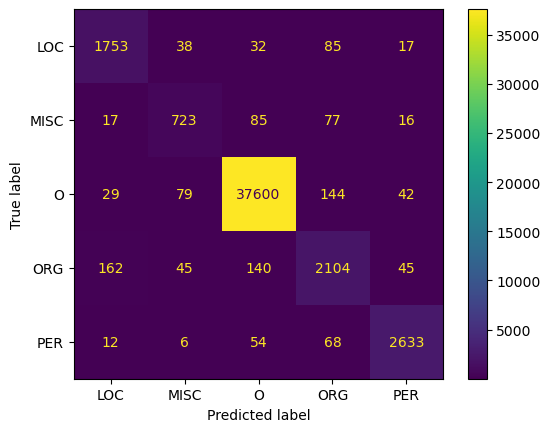

In [17]:
svm(prediction_svm)

model created
load the word embedding model
1
word embeddings retrieval for dev data is done
46006
features combined
model.predict
Output written to file.
data classified
test features extracted
              precision    recall  f1-score   support

         LOC     0.8455    0.8613    0.8533      1925
        MISC     0.6791    0.7560    0.7155       918
           O     0.9918    0.9884    0.9901     37894
         ORG     0.7911    0.7965    0.7938      2496
         PER     0.9400    0.9315    0.9357      2773

    accuracy                         0.9646     46006
   macro avg     0.8495    0.8667    0.8577     46006
weighted avg     0.9654    0.9646    0.9650     46006

[[ 1658    55    23   163    26]
 [   33   694    96    73    22]
 [   47   146 37453   200    48]
 [  179   110   150  1988    69]
 [   44    17    40    89  2583]]


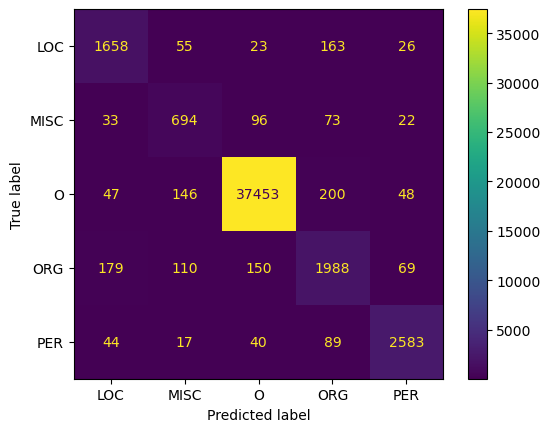

In [16]:
logreg(prediction_logreg)

In [ ]:
naive_bayes(prediction_nb,outpath_train)

In [ ]:
def random_hyperparameter_tuning(train_feat, train_label):
    # Load the dataset
    X = train_feat
    y = train_label

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the SVC model
    svc = SVC()
    #if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
    # Define the hyperparameters to tune
    param_dist = {'C': [0.1, 1, 10, 50,100], 'kernel': ['rbf'], 'gamma': ['scale']}

    # Create a RandomizedSearchCV object

    random_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_macro', random_state=42, verbose=5)

    # Fit the model to the training data
    random_search.fit(X_train, y_train)

    # Get the best parameters and the best estimator
    best_params = random_search.best_params_
    best_estimator = random_search.best_estimator_

    # Print the best parameters
    print("Best Parameters:", best_params)

    # Make predictions on the test set using the best estimator
    y_pred = best_estimator.predict(X_test)

    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print(best_params)

In [ ]:
random_hyperparameter_tuning(train_feat_combined,train_we_labels)